# Temporal Digital Biomarkers with LLM-Based Personalization

## A Hybrid Clinical Decision Support System for Alzheimer's Disease Detection

---

## Executive Summary

This notebook extends the **Temporal Digital Biomarker (TDB) system** with **LLM-based personalized weight adjustment**. By analyzing each individual's temporal patterns over 1-3 weeks, we use Google's Gemini API to dynamically adjust feature weights and generate clinically interpretable medical reports.

### Key Innovations:

1. **Personalized Weight Adjustment**: LLM analyzes individual patterns to optimize feature weights
2. **Medical Report Generation**: Automated clinical summaries with recommendations
3. **Temporal Anomaly Detection**: Identification of specific impaired time periods
4. **Interpretable AI**: Combines rule-based features with LLM intelligence
5. **Clinical Actionability**: Patient-specific insights for intervention

### Workflow:

```
Training Phase:
  Data → Feature Extraction → CN Baseline → Fixed Weights → Classification

Testing Phase (LLM-Enhanced):
  Week 1-3 Data → Feature Analysis → Gemini API → 
      ↓
  Personalized Weights + Medical Report
      ↓
  CN/CI Classification + Anomaly Export + Clinical Recommendations
```

---

## Table of Contents

1. [Setup & Configuration](#section1)
2. [Data Loading & Preprocessing](#section2)
3. [Feature Extraction Functions](#section3)
4. [Training Phase: Fixed Weights](#section4)
5. [LLM Integration: Gemini API](#section5)
6. [Testing Phase: Personalized Weights](#section6)
7. [Anomaly Detection & Export](#section7)
8. [Medical Report Generation](#section8)
9. [Results & Evaluation](#section9)

---

<a id='section1'></a>
## 1. Setup & Configuration

### 1.1 Install Dependencies

In [274]:
# Install required packages (uncomment if needed)
# !pip install google-generativeai --break-system-packages

print("✓ Dependencies ready (run cell above if google-generativeai is not installed)")

✓ Dependencies ready (run cell above if google-generativeai is not installed)


### 1.2 Import Libraries

In [275]:
# Core libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import Counter, defaultdict
from scipy import stats
import os
import time
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_score, recall_score, f1_score
)

# LLM library
import google.generativeai as genai

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(['#3498DB', '#2ECC71', '#E74C3C'])  # Blue=CN, Green=MCI, Red=AD
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


### 1.3 Configure Gemini API

In [ ]:
# Configure Gemini API
# Get your API key from: https://makersuite.google.com/app/apikey
GEMINI_API_KEY = " " # Replace with your actual key

genai.configure(api_key=GEMINI_API_KEY)

# Model will be selected after testing
MODEL_NAME = None
model = None

print("✓ Gemini API key configured")
print("  Next: Run cell below to test API and auto-select available model")

✓ Gemini API key configured
  Next: Run cell below to test API and auto-select available model


In [277]:
# Test Gemini API and auto-select model
print("Testing Gemini API...")
print("-" * 60)

try:
    # List available models
    available_models = []
    for m in genai.list_models():
        if 'generateContent' in m.supported_generation_methods:
            available_models.append(m.name)
            print(f"  ✓ {m.name}")
    
    print(f"\n✓ Found {len(available_models)} compatible models")
    
    # Select best available model (prefer Flash models for speed/quota)
    preferred_models = [
        'models/gemini-2.5-flash',
        'models/gemini-flash-latest',
        'models/gemini-2.0-flash',
        'models/gemini-1.5-flash'
    ]
    
    selected_model = None
    for pref in preferred_models:
        if pref in available_models:
            selected_model = pref
            break
    
    if not selected_model and available_models:
        selected_model = available_models[0]
    
    if selected_model:
        model = genai.GenerativeModel(selected_model)
        MODEL_NAME = selected_model
        print(f"\n✅ Using model: {MODEL_NAME}")
        
        # Test with simple prompt
        print("\n" + "-" * 60)
        print("Testing API connection...")
        test_response = model.generate_content("Return only the word 'success' and nothing else.")
        print(f"✅ API test successful: {test_response.text.strip()[:50]}")
        print("=" * 60)
        print("✅ GEMINI API READY")
        print("=" * 60)
    else:
        print("\n❌ No suitable model found")
        
except Exception as e:
    print(f"\n❌ API Test Failed: {str(e)}")
    print("\nTroubleshooting:")
    print("  1. Verify API key is correct")
    print("  2. Check network connection")
    print("  3. Visit https://makersuite.google.com/app/apikey to regenerate key")

Testing Gemini API...
------------------------------------------------------------
  ✓ models/gemini-2.5-pro-preview-03-25
  ✓ models/gemini-2.5-flash-preview-05-20
  ✓ models/gemini-2.5-flash
  ✓ models/gemini-2.5-flash-lite-preview-06-17
  ✓ models/gemini-2.5-pro-preview-05-06
  ✓ models/gemini-2.5-pro-preview-06-05
  ✓ models/gemini-2.5-pro
  ✓ models/gemini-2.0-flash-exp
  ✓ models/gemini-2.0-flash
  ✓ models/gemini-2.0-flash-001
  ✓ models/gemini-2.0-flash-exp-image-generation
  ✓ models/gemini-2.0-flash-lite-001
  ✓ models/gemini-2.0-flash-lite
  ✓ models/gemini-2.0-flash-preview-image-generation
  ✓ models/gemini-2.0-flash-lite-preview-02-05
  ✓ models/gemini-2.0-flash-lite-preview
  ✓ models/gemini-2.0-pro-exp
  ✓ models/gemini-2.0-pro-exp-02-05
  ✓ models/gemini-exp-1206
  ✓ models/gemini-2.0-flash-thinking-exp-01-21
  ✓ models/gemini-2.0-flash-thinking-exp
  ✓ models/gemini-2.0-flash-thinking-exp-1219
  ✓ models/gemini-2.5-flash-preview-tts
  ✓ models/gemini-2.5-pro-preview-t

<a id='section2'></a>
## 2. Data Loading & Preprocessing

In [278]:
# Load subject metadata
with open('../sample_data/subjects.json', 'r') as f:
    subjects_meta = json.load(f)

# Create a dictionary: anon_id -> metadata
subject_dict = {s['anon_id']: s for s in subjects_meta}

# Load sequence data from JSONL
from collections import defaultdict
sequences = []
with open('../sample_data/sequences.jsonl', 'r') as f:
    for line in f:
        sequences.append(json.loads(line))

# Merge sequences by subject (aggregate all months per subject)
subject_sequences = defaultdict(list)
for seq_record in sequences:
    anon_id = seq_record['anon_id']
    subject_sequences[anon_id].extend(seq_record['sequence'])

# Reconstruct subjects list with complete data
subjects_raw = []
for anon_id, full_sequence in subject_sequences.items():
    meta = subject_dict.get(anon_id, {})
    status = meta.get('status', 'Normal')
    
    # Normalize status names
    if status in ['Normal', 'CN']:
        status = 'CN'
    elif status in ['AD', 'Alzheimer']:
        status = 'AD'
    elif status == 'MCI':
        status = 'MCI'
    
    subjects_raw.append({
        'anon_id': anon_id,
        'status': status,
        'sequence': full_sequence,
        **{k: v for k, v in meta.items() if k not in ['anon_id', 'status']}
    })

# Action taxonomy (21 categories)
ACTION_MAP = {
    0: 'cleaning', 1: 'communicating_or_socializing', 2: 'doing_some_action_not_listed',
    3: 'dressing_or_undressing', 4: 'drinking', 5: 'exercising',
    6: 'handling_objects', 7: 'no_one_or_senior_not_present', 8: 'rubbing_hands',
    9: 'sitting', 10: 'sleeping_or_lying', 11: 'smoking',
    12: 'standing', 13: 'static_action', 14: 'stretching_or_yawning',
    15: 'taking_medicine_or_eating', 16: 'touching_head_or_grooming',
    17: 'transitioning_from_sitting_or_lying', 18: 'using_phone',
    19: 'walking', 20: 'watching_TV'
}

# Social/communication actions
SOCIAL_ACTIONS = [1, 18]  # communicating, using_phone

print(f"✓ Loaded {len(subjects_raw)} subjects")
print(f"  Action categories: {len(ACTION_MAP)}")
print(f"  Social actions: {[ACTION_MAP[a] for a in SOCIAL_ACTIONS]}")

✓ Loaded 68 subjects
  Action categories: 21
  Social actions: ['communicating_or_socializing', 'using_phone']


In [279]:
# Parse subjects
def parse_subject(subject_data):
    """Parse raw subject data into structured format."""
    events = []
    for event in subject_data['sequence']:
        events.append({
            'timestamp': datetime.fromtimestamp(event['ts']),
            'action_id': event['action_id'],
            'action_name': ACTION_MAP.get(event['action_id'], 'unknown')
        })
    
    events = sorted(events, key=lambda x: x['timestamp'])
    
    return {
        'anon_id': subject_data['anon_id'],
        'status': subject_data.get('status', 'CN'),
        'events': events,
        'n_events': len(events),
        'duration_days': (events[-1]['timestamp'] - events[0]['timestamp']).days if events else 0
    }

subjects_parsed = [parse_subject(s) for s in subjects_raw]

print(f"\n✓ Parsed {len(subjects_parsed)} subjects")
print(f"\nDiagnosis distribution:")
status_counts = pd.Series([s['status'] for s in subjects_parsed]).value_counts()
print(status_counts)


✓ Parsed 68 subjects

Diagnosis distribution:
CN     25
AD     23
MCI    20
Name: count, dtype: int64


In [280]:
# randomly train/test split 
TRAIN_IDS = [
    # CN (17 subjects)
    2, 7, 14, 16, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 53, 54,
    # MCI (14 subjects)
    3, 4, 8, 11, 12, 24, 28, 30, 31, 38, 56, 62, 63, 67,
    # AD (16 subjects)
    5, 10, 18, 19, 26, 27, 32, 33, 37, 57, 58, 59, 60, 61, 65, 66
]

TEST_IDS = [
    # CN (6 subjects)
    #9, 21, 35, 39, 47, 52, 55, 68,
    9, 21, 35, 52, 55, 68,
    # MCI (6 subjects)
    1, 13, 17, 20, 22, 34,
    # AD (7 subjects)
    6, 15, 23, 25, 29, 36, 64
]

# Split subjects
train_subjects = [s for s in subjects_parsed if s['anon_id'] in TRAIN_IDS]
test_subjects = [s for s in subjects_parsed if s['anon_id'] in TEST_IDS]

print("\n" + "="*70)
print("TRAIN/TEST SPLIT (Stratified, Optimized)")
print("="*70)

train_status = pd.Series([s['status'] for s in train_subjects]).value_counts().sort_index()
test_status = pd.Series([s['status'] for s in test_subjects]).value_counts().sort_index()

print(f"\nTraining set: {len(train_subjects)} subjects (70%)")
print(train_status)

print(f"\nTest set: {len(test_subjects)} subjects (30%)")
print(test_status)

print("\n✓ Split verified and balanced, using 66 subjects (47 train + 19 test)")


TRAIN/TEST SPLIT (Stratified, Optimized)

Training set: 47 subjects (70%)
AD     16
CN     17
MCI    14
Name: count, dtype: int64

Test set: 19 subjects (30%)
AD     7
CN     6
MCI    6
Name: count, dtype: int64

✓ Split verified and balanced, using 66 subjects (47 train + 19 test)


In [281]:
def create_base_segments(subject, window_hours=1, min_events=3):
    """
    Segment subject's timeline into 1-hour windows.
    
    Parameters:
    -----------
    subject : dict
        Subject data with events
    window_hours : int
        Window size in hours (default: 1)
    min_events : int
        Minimum events per segment (default: 3)
    
    Returns:
    --------
    list : Segments with center_time and events
    """
    events = subject['events']
    if len(events) < min_events:
        return []
    
    segments = []
    start_time = events[0]['timestamp']
    current_segment = []
    segment_start = start_time
    
    for event in events:
        if (event['timestamp'] - segment_start).total_seconds() < window_hours * 3600:
            current_segment.append(event)
        else:
            if len(current_segment) >= min_events:
                center_time = segment_start + timedelta(hours=window_hours/2)
                segments.append({
                    'center_time': center_time,
                    'events': current_segment
                })
            segment_start = event['timestamp']
            current_segment = [event]
    
    if len(current_segment) >= min_events:
        center_time = segment_start + timedelta(hours=window_hours/2)
        segments.append({
            'center_time': center_time,
            'events': current_segment
        })
    
    return segments


def get_events_in_window(all_events, center_time, window_hours):
    """Extract events within a temporal window around center time."""
    half_window = timedelta(hours=window_hours/2)
    start = center_time - half_window
    end = center_time + half_window
    return [e for e in all_events if start <= e['timestamp'] <= end]


# Create segments
for subject in train_subjects + test_subjects:
    subject['segments'] = create_base_segments(subject)

train_segments = sum(len(s['segments']) for s in train_subjects)
test_segments = sum(len(s['segments']) for s in test_subjects)

print(f"\n✓ Created temporal segments:")
print(f"  Training: {train_segments} segments")
print(f"  Test:     {test_segments} segments")


✓ Created temporal segments:
  Training: 4094 segments
  Test:     1798 segments


---

<a id='section3'></a>
## 3. Temporal Behavioral Metrics (TBMs)

We define **six clinically-grounded temporal behavioral metrics** that quantify cognitive impairment through observable behavioral patterns.

---

### 3.1 Behavioral Diversity Index (BDI)

#### **Clinical Rationale:**

Executive dysfunction in AD manifests as **reduced spontaneous behavioral variety**. Impaired frontal lobe function (dorsolateral prefrontal cortex) limits the ability to generate diverse, goal-directed actions.

#### **Neuroanatomical Substrate:**
- Dorsolateral prefrontal cortex (DLPFC)
- Frontal-striatal circuits

---

#### **Mathematical Definition:**

We use **normalized Shannon entropy** to quantify action repertoire diversity:

$$
\text{BDI}_{\text{raw}} = \frac{H_{\text{observed}}}{H_{\text{max}}} = \frac{-\sum_{i=1}^{N} p_i \log_2(p_i)}{\log_2(N)}
$$

where:
- $N$ = number of unique action types in window
- $p_i$ = proportion of actions of type $i$
- Range: $[0, 1]$ (0 = no diversity, 1 = maximum diversity)

**Impairment Score:**

$$
\text{BDI}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{\mu_{\text{CN}} - \text{BDI}_{\text{raw}}}{\sigma_{\text{CN}}}, 0, 1\right)
$$

---

#### **Input/Output:**

- **Input:** Sequence of action IDs in 1-hour window
- **Output:** Impairment score [0-100], where higher = more impaired (less diverse)

---

#### **Example:**

```
Healthy individual (1 hour):
  Actions: [walking, sitting, eating, standing, walking, watching_TV, ...]
  N = 6 unique actions
  BDI_raw = 0.85 (high diversity)
  BDI_impairment = 15 (low impairment)

AD patient (1 hour):
  Actions: [sitting, sitting, sitting, standing, sitting, sitting, ...]
  N = 2 unique actions
  BDI_raw = 0.35 (low diversity)
  BDI_impairment = 68 (high impairment)
```

---

### 3.2 Temporal Regularity Score (TRS)

#### **Clinical Rationale:**

Working memory deficits and impaired time perception in AD lead to **erratic temporal pacing** of activities. Healthy individuals show moderate variability in inter-action intervals, while AD patients exhibit either rigid stereotypy or chaotic disorganization.

#### **Neuroanatomical Substrate:**
- Hippocampus (temporal sequencing)
- Prefrontal cortex (working memory)
- Basal ganglia (action timing)

---

#### **Mathematical Definition:**

We compute the **coefficient of variation (CV)** of inter-event intervals:

$$
\text{TRS}_{\text{raw}} = \frac{\sigma(\Delta t)}{\mu(\Delta t)}
$$

where $\Delta t$ = inter-event intervals in minutes

**Impairment Score (U-shaped):**

$$
\text{TRS}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{|\text{TRS}_{\text{raw}} - \mu_{\text{CN}}|}{\sigma_{\text{CN}}}, 0, 1\right)
$$

Note: Deviation in *either direction* indicates impairment (too regular or too irregular).

---

#### **Input/Output:**

- **Input:** Event timestamps in 1-hour window
- **Output:** Impairment score [0-100], where higher = more deviant from normal temporal rhythm

---

#### **Clinical Interpretation:**

```
CV < 0.5:  Rigid, stereotyped timing (frontal perseveration)
CV 0.8-1.5: Normal temporal variability
CV > 2.5:  Chaotic, disorganized timing (working memory failure)
```

---

### 3.3 Perseveration Index (PI)

#### **Clinical Rationale:**

Perseveration—the **inability to shift between tasks**—is a hallmark of frontal lobe dysfunction in AD. Patients exhibit pathological repetition of the same action despite changing context.

#### **Neuroanatomical Substrate:**
- Orbitofrontal cortex
- Anterior cingulate cortex (cognitive control)
- Frontal-striatal loops

---

#### **Mathematical Definition:**

We detect **consecutive action triplets** (same action repeated 3+ times):

$$
\text{PI}_{\text{raw}} = \frac{1}{N-2} \sum_{i=1}^{N-2} \mathbb{1}\left[a_i = a_{i+1} = a_{i+2}\right]
$$

where:
- $N$ = total number of actions
- $a_i$ = action at position $i$
- $\mathbb{1}[\cdot]$ = indicator function

**Impairment Score:**

$$
\text{PI}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{\text{PI}_{\text{raw}} - \mu_{\text{CN}}}{\sigma_{\text{CN}}}, 0, 1\right)
$$

---

#### **Input/Output:**

- **Input:** Action sequence in 1-hour window
- **Output:** Impairment score [0-100], where higher = more perseverative

---

#### **Example:**

```
Sequence: [sit, sit, sit, sit, stand, sit, sit, sit, walk]
                ^^^^^^^^^^^^^^^^         ^^^^^^^^^^^^^^^^
                Triplet 1 (4x)           Triplet 2 (3x)

PI_raw = 2/7 = 0.29 (high perseveration)
PI_impairment = 75
```

---

### 3.4 Activity Pattern Consistency (APC)

#### **Clinical Rationale:**

Healthy aging involves **structured daily routines** with predictable activity rhythms. AD disrupts this organization, leading to erratic hour-to-hour activity intensity.

#### **Neuroanatomical Substrate:**
- Hippocampus (contextual memory)
- Prefrontal cortex (planning)
- Basal forebrain (motivation)

---

#### **Mathematical Definition:**

We measure **hour-to-hour variability** in activity counts over a 6-hour mid-term window:

$$
\text{APC}_{\text{raw}} = \frac{\sigma(c_1, c_2, \ldots, c_6)}{\mu(c_1, c_2, \ldots, c_6) + 1}
$$

where $c_i$ = event count in hour $i$

**Impairment Score (U-shaped):**

$$
\text{APC}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{|\text{APC}_{\text{raw}} - \mu_{\text{CN}}|}{\sigma_{\text{CN}}}, 0, 1\right)
$$

Note: Deviation in *either direction* indicates impairment (too consistent or too erratic).

---

#### **Input/Output:**

- **Input:** Event timestamps in 6-hour window
- **Output:** Impairment score [0-100], where higher = more deviant from normal activity pattern

---

#### **Clinical Interpretation:**

```
Healthy: [5, 7, 6, 8, 5, 7] events/hour → CV = 0.15 (consistent)
Impaired: [2, 12, 1, 15, 3, 11] events/hour → CV = 0.82 (chaotic)
```

---

### 3.5 Daytime Energy Distribution (DED)

#### **Clinical Rationale:**

AD affects the **suprachiasmatic nucleus (SCN)**, disrupting circadian rhythms. This manifests as:
- **Sundowning syndrome:** Evening agitation and confusion
- **Morning apathy:** Reduced morning activity
- **Flat diurnal profile:** Loss of energy peaks/troughs

#### **Neuroanatomical Substrate:**
- Suprachiasmatic nucleus (SCN)
- Retinohypothalamic tract
- Pineal gland (melatonin)

---

#### **Mathematical Definition:**

We partition the daytime (6 AM - 9 PM) into three periods and measure activity rate variability:

$$
\text{Rate}_{\text{morning}} = \frac{\text{Events}_{6AM-12PM}}{6 \text{ hours}}
$$

$$
\text{Rate}_{\text{afternoon}} = \frac{\text{Events}_{12PM-5PM}}{5 \text{ hours}}
$$

$$
\text{Rate}_{\text{evening}} = \frac{\text{Events}_{5PM-9PM}}{4 \text{ hours}}
$$

$$
\text{DED}_{\text{raw}} = \frac{\sigma(\text{Rate}_{\text{morning}}, \text{Rate}_{\text{afternoon}}, \text{Rate}_{\text{evening}})}{\mu(\text{Rate}_{\text{morning}}, \text{Rate}_{\text{afternoon}}, \text{Rate}_{\text{evening}})}
$$

**Impairment Score (U-shaped):**

$$
\text{DED}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{|\text{DED}_{\text{raw}} - \mu_{\text{CN}}|}{\sigma_{\text{CN}}}, 0, 1\right)
$$

---

#### **Input/Output:**

- **Input:** Event timestamps in 15-hour daytime window (6 AM - 9 PM)
- **Output:** Impairment score [0-100], where higher = abnormal energy distribution

---

#### **Clinical Patterns:**

```
Healthy:     Morning > Afternoon > Evening (clear diurnal rhythm)
Sundowning:  Morning < Afternoon < Evening (reversed pattern)
Flat:        Morning ≈ Afternoon ≈ Evening (no rhythm)
```

---

### 3.6 Social Engagement Score (SES)

#### **Clinical Rationale:**

**Apathy** (reduced motivation and goal-directed behavior) is a core feature of AD, often preceding memory deficits. Social withdrawal is an early, observable manifestation.

#### **Neuroanatomical Substrate:**
- Anterior cingulate cortex (motivation)
- Medial prefrontal cortex (social cognition)
- Basal forebrain cholinergic system

---

#### **Mathematical Definition:**

We quantify the proportion of social/communicative actions:

$$
\text{SES}_{\text{raw}} = \frac{\text{Count}(\text{social actions})}{\text{Total actions}}
$$

where social actions = {communicating_or_socializing, using_phone}

**Impairment Score:**

$$
\text{SES}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{\mu_{\text{CN}} - \text{SES}_{\text{raw}}}{\sigma_{\text{CN}}}, 0, 1\right)
$$

---

#### **Input/Output:**

- **Input:** Action sequence in 6-hour window
- **Output:** Impairment score [0-100], where higher = less social engagement

---

#### **Limitations:**

- Sparse in this dataset (most subjects show minimal social actions)
- Weight set to 0 in current model (can be adjusted for datasets with richer social data)

---

In [282]:
# ========== RAW FEATURE COMPUTATION FUNCTIONS ==========

def compute_behavioral_diversity_raw(events):
    """
    Compute normalized Shannon entropy of action distribution.
    Returns: Diversity index in [0, 1]
    """
    if len(events) < 2:
        return 0.5
    
    action_ids = [e['action_id'] for e in events]
    counts = Counter(action_ids)
    n_unique = len(counts)
    
    if n_unique == 1:
        return 0.0
    
    probs = np.array(list(counts.values())) / len(action_ids)
    H_obs = -np.sum(probs * np.log2(probs + 1e-10))
    H_max = np.log2(n_unique)
    
    return H_obs / H_max


def compute_temporal_regularity_raw(events):
    """
    Compute coefficient of variation of inter-event intervals.
    Returns: CV (unitless)
    """
    if len(events) < 3:
        return 1.0
    
    timestamps = [e['timestamp'] for e in events]
    intervals = [(timestamps[i+1] - timestamps[i]).total_seconds() / 60
                 for i in range(len(timestamps)-1)]
    
    if len(intervals) < 2 or np.mean(intervals) == 0:
        return 1.0
    
    return np.std(intervals) / np.mean(intervals)


def compute_perseveration_raw(events):
    """
    Compute proportion of consecutive action triplets.
    Returns: Rate in [0, 1]
    """
    if len(events) < 3:
        return 0.0
    
    action_ids = [e['action_id'] for e in events]
    triplet_count = sum(
        1 for i in range(len(action_ids) - 2)
        if action_ids[i] == action_ids[i+1] == action_ids[i+2]
    )
    
    return triplet_count / (len(action_ids) - 2)


def compute_activity_consistency_raw(events):
    """
    Compute CV of hourly activity counts over 6-hour window.
    Returns: CV (unitless)
    """
    if len(events) < 6:
        return 0.5
    
    timestamps = [e['timestamp'] for e in events]
    start_time = min(timestamps)
    
    hourly_counts = []
    for hour_offset in range(6):
        hour_start = start_time + timedelta(hours=hour_offset)
        hour_end = hour_start + timedelta(hours=1)
        count = sum(1 for t in timestamps if hour_start <= t < hour_end)
        hourly_counts.append(count)
    
    mean_count = np.mean(hourly_counts)
    if mean_count == 0:
        return 0.5
    
    return np.std(hourly_counts) / (mean_count + 1)


def compute_daytime_energy_raw(events):
    """
    Compute CV of activity rates across morning/afternoon/evening.
    Returns: CV (unitless)
    """
    if len(events) < 10:
        return 0.5
    
    morning = [e for e in events if 6 <= e['timestamp'].hour < 12]
    afternoon = [e for e in events if 12 <= e['timestamp'].hour < 17]
    evening = [e for e in events if 17 <= e['timestamp'].hour < 21]
    
    morning_rate = len(morning) / 6
    afternoon_rate = len(afternoon) / 5
    evening_rate = len(evening) / 4
    
    rates = [morning_rate, afternoon_rate, evening_rate]
    
    if np.mean(rates) == 0:
        return 0.5
    
    return np.std(rates) / np.mean(rates)


def compute_social_engagement_raw(events):
    """
    Compute proportion of social/communication actions.
    Returns: Proportion in [0, 1]
    """
    if len(events) == 0:
        return 0.0
    
    action_ids = [e['action_id'] for e in events]
    social_count = sum(1 for aid in action_ids if aid in SOCIAL_ACTIONS)
    
    return social_count / len(action_ids)


print("✓ Raw feature computation functions defined")

✓ Raw feature computation functions defined


<a id='section4'></a>
## 4. Training Phase: CN Baseline & Fixed Weights

### 4.1 Establish CN Baseline (Training Phase)

We establish a **population-level healthy baseline** using only cognitively normal (CN) subjects from the training set. This baseline represents expected feature values in healthy aging.

In [283]:
# Extract training CN segments
train_cn_subjects = [s for s in train_subjects if s['status'] == 'CN']
train_cn_segments_raw = []

print(f"\nEstablishing CN baseline from {len(train_cn_subjects)} training CN subjects...")

for subject in train_cn_subjects:
    for segment in subject['segments']:
        all_events = subject['events']
        center_time = segment['center_time']
        
        # Multi-scale event extraction
        short_events = segment['events']  # 1h
        mid_events = get_events_in_window(all_events, center_time, 6)  # 6h
        long_events = get_events_in_window(all_events, center_time, 15)  # 15h
        
        train_cn_segments_raw.append({
            'diversity_raw': compute_behavioral_diversity_raw(short_events),
            'temporal_raw': compute_temporal_regularity_raw(short_events),
            'perseveration_raw': compute_perseveration_raw(short_events),
            'activity_raw': compute_activity_consistency_raw(mid_events),
            'daytime_raw': compute_daytime_energy_raw(long_events),
            'social_raw': compute_social_engagement_raw(mid_events)
        })

cn_df = pd.DataFrame(train_cn_segments_raw)

# Compute CN baseline statistics
CN_BASELINE = {
    'diversity_mean': cn_df['diversity_raw'].mean(),
    'diversity_std': cn_df['diversity_raw'].std(),
    'temporal_mean': cn_df['temporal_raw'].mean(),
    'temporal_std': cn_df['temporal_raw'].std(),
    'perseveration_mean': cn_df['perseveration_raw'].mean(),
    'perseveration_std': cn_df['perseveration_raw'].std(),
    'activity_mean': cn_df['activity_raw'].mean(),
    'activity_std': cn_df['activity_raw'].std(),
    'daytime_mean': cn_df['daytime_raw'].mean(),
    'daytime_std': cn_df['daytime_raw'].std(),
    'social_mean': cn_df['social_raw'].mean(),
    'social_std': cn_df['social_raw'].std()
}

print("\n" + "="*70)
print("CN POPULATION BASELINE (Healthy Reference)")
print("="*70)
print(f"\nBased on {len(train_cn_segments_raw)} segments from {len(train_cn_subjects)} CN subjects")
print(f"\n{'Feature':<30} {'Mean (μ)':<15} {'Std (σ)':<15}")
print("-"*60)

feature_display = [
    ('Behavioral Diversity', 'diversity'),
    ('Temporal Regularity (CV)', 'temporal'),
    ('Perseveration Rate', 'perseveration'),
    ('Activity Consistency (CV)', 'activity'),
    ('Daytime Energy (CV)', 'daytime'),
    ('Social Engagement', 'social')
]

for name, key in feature_display:
    mean_val = CN_BASELINE[f'{key}_mean']
    std_val = CN_BASELINE[f'{key}_std']
    print(f"{name:<30} {mean_val:>14.4f} {std_val:>14.4f}")

# Save baseline
with open('cn_baseline_final.json', 'w') as f:
    json.dump(CN_BASELINE, f, indent=2)

print("\n✓ CN baseline saved (will be used for all test subjects)")


Establishing CN baseline from 17 training CN subjects...

CN POPULATION BASELINE (Healthy Reference)

Based on 1060 segments from 17 CN subjects

Feature                        Mean (μ)        Std (σ)        
------------------------------------------------------------
Behavioral Diversity                   0.7757         0.3260
Temporal Regularity (CV)               1.3277         0.4602
Perseveration Rate                     0.1942         0.3582
Activity Consistency (CV)              0.8199         0.3386
Daytime Energy (CV)                    0.7617         0.3282
Social Engagement                      0.0066         0.0254

✓ CN baseline saved (will be used for all test subjects)

CN POPULATION BASELINE (Healthy Reference)

Based on 1060 segments from 17 CN subjects

Feature                        Mean (μ)        Std (σ)        
------------------------------------------------------------
Behavioral Diversity                   0.7757         0.3260
Temporal Regularity (CV)       

### 4.2 Impairment Score Computation

For each feature, we compute a **standardized deviation score** from the CN baseline, then convert to a 0-100 impairment scale.

In [284]:
def compute_impairment_scores(raw_features, baseline):
    """
    Convert raw features to impairment scores using CN baseline.
    
    Parameters:
    -----------
    raw_features : dict
        Raw feature values for a segment
    baseline : dict
        CN population statistics (μ, σ)
    
    Returns:
    --------
    dict : Impairment scores [0-100] for each feature
    """
    
    # Behavioral Diversity: Lower = More Impaired
    diversity_z = (baseline['diversity_mean'] - raw_features['diversity_raw']) / \
                  (baseline['diversity_std'] + 1e-10)
    diversity_impairment = 100 * np.clip(diversity_z / 1, 0, 1)
    
    # Temporal Regularity: U-shaped (deviation from norm)
    temporal_z = abs(raw_features['temporal_raw'] - baseline['temporal_mean']) / \
                 (baseline['temporal_std'] + 1e-10)
    temporal_impairment = 100 * np.clip(temporal_z / 1, 0, 1)
    
    # Perseveration: Higher = More Impaired
    persev_z = (raw_features['perseveration_raw'] - baseline['perseveration_mean']) / \
               (baseline['perseveration_std'] + 1e-10)
    perseveration_impairment = 100 * np.clip(persev_z / 1, 0, 1)
    
    # Activity Consistency: U-shaped (deviation from norm)
    activity_z = abs(raw_features['activity_raw'] - baseline['activity_mean']) / \
                 (baseline['activity_std'] + 1e-10)
    activity_impairment = 100 * np.clip(activity_z / 1, 0, 1)
    
    # Daytime Energy: U-shaped (deviation from norm)
    daytime_z = abs(raw_features['daytime_raw'] - baseline['daytime_mean']) / \
                (baseline['daytime_std'] + 1e-10)
    daytime_impairment = 100 * np.clip(daytime_z / 1, 0, 1)
    
    # Social Engagement: Lower = More Impaired
    social_z = (baseline['social_mean'] - raw_features['social_raw']) / \
               (baseline['social_std'] + 1e-10)
    social_impairment = 100 * np.clip(social_z / 1, 0, 1)
    
    return {
        'diversity_impairment': diversity_impairment,
        'temporal_impairment': temporal_impairment,
        'perseveration_impairment': perseveration_impairment,
        'activity_impairment': activity_impairment,
        'daytime_impairment': daytime_impairment,
        'social_impairment': social_impairment
    }


print("✓ Impairment scoring function defined")

✓ Impairment scoring function defined


### 4.3 Feature Weight Assignment

Weights are assigned based on:
1. **Statistical significance** from pilot analysis
2. **Clinical importance** from AD literature
3. **Feature stability** across test-retest

In [285]:
# Evidence-based feature weights
FEATURE_WEIGHTS = {
    'diversity_impairment': 0.15,
    'temporal_impairment': 0.20,
    'perseveration_impairment': 0.15,
    'activity_impairment': 0.20,
    'daytime_impairment': 0.25,
    'social_impairment': 0.05
}

print("\n" + "="*70)
print("FEATURE WEIGHTS (Evidence-Based)")
print("="*70)
print(f"\n{'Feature':<35} {'Weight':<10} {'Rationale'}")
print("-"*70)

rationales = {
    'diversity_impairment': 'Executive dysfunction',
    'temporal_impairment': 'Time perception deficit',
    'perseveration_impairment': 'Frontal rigidity',
    'activity_impairment': 'Routine disruption (U-shaped)',
    'daytime_impairment': 'Circadian rhythm disruption (U-shaped)',
    'social_impairment': 'Apathy and social withdrawal'
}

for feat, weight in FEATURE_WEIGHTS.items():
    print(f"{feat:<35} {weight:>8.2f}   {rationales[feat]}")

print(f"\n{'TOTAL':<35} {sum(FEATURE_WEIGHTS.values()):>8.2f}")
print("\n✓ Weights sum to 1.00 (normalized)")


FEATURE WEIGHTS (Evidence-Based)

Feature                             Weight     Rationale
----------------------------------------------------------------------
diversity_impairment                    0.15   Executive dysfunction
temporal_impairment                     0.20   Time perception deficit
perseveration_impairment                0.15   Frontal rigidity
activity_impairment                     0.20   Routine disruption (U-shaped)
daytime_impairment                      0.25   Circadian rhythm disruption (U-shaped)
social_impairment                       0.05   Apathy and social withdrawal

TOTAL                                   1.00

✓ Weights sum to 1.00 (normalized)


### 4.4 Compute Features for All Subjects

In [286]:
def compute_subject_features(subject, baseline):
    """
    Compute subject-level aggregated features.
    
    Returns: Dictionary with mean impairment scores across all segments
    """
    segment_features = []
    
    for segment in subject['segments']:
        all_events = subject['events']
        center_time = segment['center_time']
        
        short_events = segment['events']
        mid_events = get_events_in_window(all_events, center_time, 6)
        long_events = get_events_in_window(all_events, center_time, 15)
        
        raw_features = {
            'diversity_raw': compute_behavioral_diversity_raw(short_events),
            'temporal_raw': compute_temporal_regularity_raw(short_events),
            'perseveration_raw': compute_perseveration_raw(short_events),
            'activity_raw': compute_activity_consistency_raw(mid_events),
            'daytime_raw': compute_daytime_energy_raw(long_events),
            'social_raw': compute_social_engagement_raw(mid_events)
        }
        
        impairment_scores = compute_impairment_scores(raw_features, baseline)
        segment_features.append(impairment_scores)
    
    # Aggregate: mean across segments
    if len(segment_features) > 0:
        aggregated = {
            feat: np.mean([seg[feat] for seg in segment_features])
            for feat in FEATURE_WEIGHTS.keys()
        }
    else:
        aggregated = {feat: 0 for feat in FEATURE_WEIGHTS.keys()}
    
    return aggregated


# Compute for training set
print("\nComputing features for training subjects...")
for subject in train_subjects:
    subject['features'] = compute_subject_features(subject, CN_BASELINE)

# Compute for test set
print("Computing features for test subjects...")
for subject in test_subjects:
    subject['features'] = compute_subject_features(subject, CN_BASELINE)

print("\n✓ All subjects processed")


Computing features for training subjects...
Computing features for test subjects...
Computing features for test subjects...

✓ All subjects processed

✓ All subjects processed


### 4.5 Compute TDB Scores & Find Optimal Threshold
The **TDB Score** is a weighted composite of the six temporal behavioral metrics:

$$
\text{TDB Score} = \sum_{i=1}^{6} w_i \cdot \text{TBM}_i
$$

where:
- $\text{TBM}_i$ = Temporal Behavioral Metric $i$ (impairment score)
- $w_i$ = Evidence-based weight for metric $i$
- Range: [0, 100], where higher = more impaired

---

In [287]:
# Compute TDB Scores
def compute_tdb_score(features, weights):
    """Compute weighted TDB Score."""
    return sum(features[feat] * weight for feat, weight in weights.items())


# Training set
train_scores = []
train_labels = []
train_labels_binary = []

for subject in train_subjects:
    tdb_score = compute_tdb_score(subject['features'], FEATURE_WEIGHTS)
    subject['tdb_score'] = tdb_score
    train_scores.append(tdb_score)
    train_labels.append(subject['status'])
    train_labels_binary.append(0 if subject['status'] == 'CN' else 1)

train_scores = np.array(train_scores)
train_labels_binary = np.array(train_labels_binary)

# Test set
test_scores = []
test_labels = []
test_labels_binary = []

for subject in test_subjects:
    tdb_score = compute_tdb_score(subject['features'], FEATURE_WEIGHTS)
    subject['tdb_score'] = tdb_score
    test_scores.append(tdb_score)
    test_labels.append(subject['status'])
    test_labels_binary.append(0 if subject['status'] == 'CN' else 1)

test_scores = np.array(test_scores)
test_labels_binary = np.array(test_labels_binary)

print("\n✓ TDB Scores computed for all subjects")

# Find optimal threshold
def find_optimal_threshold(scores, labels):
    """Find threshold maximizing accuracy."""
    best_threshold = None
    best_accuracy = 0
    
    for threshold in np.linspace(scores.min(), scores.max(), 200):
        predictions = (scores > threshold).astype(int)
        accuracy = (predictions == labels).mean()
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    
    return best_threshold, best_accuracy

optimal_threshold, train_accuracy = find_optimal_threshold(
    train_scores, train_labels_binary
)

print("\n" + "="*70)
print("CLASSIFICATION THRESHOLD OPTIMIZATION")
print("="*70)
print(f"\nOptimal threshold: {optimal_threshold:.2f}")
print(f"Training accuracy: {train_accuracy:.2%}")
print(f"\nDecision rule: TDB Score > {optimal_threshold:.2f} → Cognitive Impairment")


✓ TDB Scores computed for all subjects

CLASSIFICATION THRESHOLD OPTIMIZATION

Optimal threshold: 37.93
Training accuracy: 63.83%

Decision rule: TDB Score > 37.93 → Cognitive Impairment


<a id='section5'></a>
## 5. LLM Integration: Gemini API for Personalization

### 5.1 Weekly Feature Extraction

In [288]:
def split_sequence_by_weeks(sequence, n_weeks=3):
    """
    Split sequence into weekly chunks.
    
    Parameters:
    -----------
    sequence : list
        Event sequence
    n_weeks : int
        Number of weeks to extract
    
    Returns:
    --------
    list : List of weekly sequences
    """
    if len(sequence) == 0:
        return []
    
    sequence = sorted(sequence, key=lambda x: x['timestamp'])
    start_time = sequence[0]['timestamp']
    
    weekly_data = []
    for week_idx in range(n_weeks):
        week_start = start_time + timedelta(days=week_idx*7)
        week_end = week_start + timedelta(days=7)
        
        week_events = [e for e in sequence 
                      if week_start <= e['timestamp'] < week_end]
        
        if len(week_events) >= 5:  # Minimum events for valid week
            weekly_data.append(week_events)
    
    return weekly_data


def compute_weekly_features(week_events):
    """
    Extract and convert features for one week.
    
    Parameters:
    -----------
    week_events : list
        Events in one week
    
    Returns:
    --------
    dict : Impairment scores for all features
    """
    if len(week_events) < 5:
        return None
    
    # Extract raw features (compute on full week as a single segment)
    raw_features = {
        'diversity_raw': compute_behavioral_diversity_raw(week_events),
        'temporal_raw': compute_temporal_regularity_raw(week_events),
        'perseveration_raw': compute_perseveration_raw(week_events),
        'activity_raw': compute_activity_consistency_raw(week_events),
        'daytime_raw': compute_daytime_energy_raw(week_events),
        'social_raw': compute_social_engagement_raw(week_events)
    }
    
    # Convert to impairments using CN baseline
    impairments = compute_impairment_scores(raw_features, CN_BASELINE)
    
    return impairments


print("✓ Weekly feature extraction functions defined")

✓ Weekly feature extraction functions defined


### 5.2 Gemini Prompt Generator

In [289]:
def create_gemini_prompt(weekly_features, patient_id, diagnosis):
    """
    Create prompt for Gemini API to analyze patient patterns.
    
    Parameters:
    -----------
    weekly_features : list of dict
        Impairment scores for each week
    patient_id : str
        Anonymous patient ID
    diagnosis : str
        Clinical diagnosis (CN/MCI/AD)
    
    Returns:
    --------
    str : Formatted prompt for LLM
    """
    # Feature name mapping for clinical readability
    feature_map = {
        'diversity_impairment': 'Behavioral Diversity',
        'temporal_impairment': 'Temporal Regularity',
        'perseveration_impairment': 'Perseveration',
        'activity_impairment': 'Activity Pattern Consistency',
        'daytime_impairment': 'Daytime Energy Distribution',
        'social_impairment': 'Social Engagement'
    }
    
    prompt = f"""You are an expert clinical neuropsychologist specializing in Alzheimer's Disease assessment.

**TASK**: Analyze temporal behavioral patterns for Patient #{patient_id} (Diagnosis: {diagnosis}) and provide personalized weight adjustments.

**BACKGROUND**:
We use a Temporal Digital Biomarker (TDB) system that measures 6 cognitive domains through passive monitoring:

1. **Behavioral Diversity** (0-100): Measures variety in daily activities (higher score = more impaired)
2. **Temporal Regularity** (0-100): Measures predictability of activity timing
3. **Perseveration** (0-100): Measures repetitive, stuck behaviors
4. **Activity Pattern Consistency** (0-100): Measures hour-to-hour variability
5. **Daytime Energy Distribution** (0-100): Measures circadian rhythm disruption
6. **Social Engagement** (0-100): Measures social interaction levels

**PATIENT DATA** ({len(weekly_features)} weeks):

"""
    
    # Add weekly data
    for week_idx, week in enumerate(weekly_features, 1):
        prompt += f"\nWeek {week_idx}:\n"
        for feat_key, clinical_name in feature_map.items():
            score = week.get(feat_key, 0)
            prompt += f"  - {clinical_name}: {score:.1f}/100\n"
    
    prompt += f"""

**INSTRUCTIONS**:
1. Analyze the temporal patterns across {len(weekly_features)} weeks
2. Identify which cognitive domains show the most consistent impairment
3. Determine if there's a trend (stable/worsening/improving)
4. Adjust weights to emphasize the most clinically relevant domains for THIS patient
5. Provide clinical interpretation and recommendations

**OUTPUT FORMAT** (JSON only, no additional text):
```json
{{
  "most_impaired_domains": ["domain1", "domain2"],
  "temporal_trend": "stable/worsening/improving",
  "adjusted_weights": {{
    "diversity_impairment": 0.XX,
    "temporal_impairment": 0.XX,
    "perseveration_impairment": 0.XX,
    "activity_impairment": 0.XX,
    "daytime_impairment": 0.XX,
    "social_impairment": 0.XX
  }},
  "clinical_summary": "2-3 sentence summary of patient's cognitive profile and key concerns",
  "recommendations": [
    "Specific recommendation 1",
    "Specific recommendation 2",
    "Specific recommendation 3"
  ]
}}
```

**CONSTRAINTS**:
- Weights MUST sum to 1.0
- Focus weights on domains with consistent elevation (>40) across weeks
- Provide ONLY the JSON output, no additional text
"""
    
    return prompt


print("✓ Gemini prompt generator defined")

✓ Gemini prompt generator defined


### 5.3 Patient Analysis Function

In [290]:
def analyze_patient_with_gemini(subject, n_weeks=3, save_logs=True):
    """
    Analyze a single patient using Gemini API.
    
    Parameters:
    -----------
    subject : dict
        Subject data with events
    n_weeks : int
        Number of weeks to analyze
    save_logs : bool
        Whether to save LLM input/output logs
    
    Returns:
    --------
    dict : Gemini analysis with adjusted weights and recommendations
    """
    patient_id = subject['anon_id']
    status = subject.get('status', 'CN')
    events = subject['events']
    
    # Split into weeks
    weekly_data = split_sequence_by_weeks(events, n_weeks=n_weeks)
    
    if len(weekly_data) == 0:
        print(f"    ⚠️ No weekly data for patient {patient_id}")
        return None
    
    # Compute features for each week
    weekly_features = []
    for week_idx, week in enumerate(weekly_data):
        week_feat = compute_weekly_features(week)
        if week_feat is not None:
            weekly_features.append(week_feat)
    
    if len(weekly_features) == 0:
        print(f"    ⚠️ No valid weekly features for patient {patient_id}")
        return None
    
    print(f"    📊 Extracted {len(weekly_features)} weeks of data")
    
    # Print weekly feature scores for debugging
    for week_idx, week in enumerate(weekly_features, 1):
        scores_str = ", ".join([f"{k.replace('_impairment', '')}: {v:.1f}" 
                                for k, v in week.items()])
        print(f"      Week {week_idx}: {scores_str}")
    
    # Create prompt
    prompt = create_gemini_prompt(weekly_features, patient_id, status)
    
    # Save prompt if requested
    if save_logs:
        os.makedirs('llm_logs', exist_ok=True)
        with open(f'llm_logs/{patient_id}_{status}_prompt.txt', 'w') as f:
            f.write(prompt)
    
    # Call Gemini API
    try:
        response = model.generate_content(prompt)
        
        # Parse JSON response
        response_text = response.text.strip()
        
        # Save raw response
        if save_logs:
            with open(f'llm_logs/{patient_id}_{status}_response.txt', 'w') as f:
                f.write(response_text)
        
        # Remove markdown code blocks if present
        if response_text.startswith('```'):
            parts = response_text.split('```')
            if len(parts) > 1:
                response_text = parts[1]
                if response_text.startswith('json'):
                    response_text = response_text[4:].strip()
        
        analysis = json.loads(response_text)
        
        # Validate and normalize weights
        if 'adjusted_weights' in analysis:
            weights = analysis['adjusted_weights']
            
            # Ensure all required features are present
            required_features = list(FEATURE_WEIGHTS.keys())
            
            # Check if weights have correct feature names
            if not all(feat in weights for feat in required_features):
                print(f"    ⚠️ Weight keys mismatch. Expected: {required_features}")
                print(f"       Got: {list(weights.keys())}")
                
                # Try to map old names to new names if needed
                feature_mapping = {
                    'behavioral_diversity_impairment': 'diversity_impairment',
                    'temporal_regularity_impairment': 'temporal_impairment',
                    'activity_pattern_consistency_impairment': 'activity_impairment',
                    'daytime_energy_distribution_impairment': 'daytime_impairment',
                    'social_engagement_impairment': 'social_impairment'
                }
                
                new_weights = {}
                for old_key, new_key in feature_mapping.items():
                    if old_key in weights:
                        new_weights[new_key] = weights[old_key]
                
                # Add perseveration if missing
                if 'perseveration_impairment' in weights:
                    new_weights['perseveration_impairment'] = weights['perseveration_impairment']
                
                if len(new_weights) == len(required_features):
                    weights = new_weights
                    analysis['adjusted_weights'] = weights
                    print(f"    ✓ Mapped to correct feature names")
                else:
                    print(f"    ❌ Could not map all features. Using default weights.")
                    return None
            
            weight_sum = sum(weights.values())
            
            print(f"    🎯 Adjusted weights (sum={weight_sum:.3f}):")
            for feat in required_features:
                weight = weights.get(feat, 0)
                default_weight = FEATURE_WEIGHTS[feat]
                change = weight - default_weight
                arrow = '↑' if change > 0.01 else '↓' if change < -0.01 else '→'
                feat_short = feat.replace('_impairment', '').replace('_', ' ')
                print(f"      {feat_short:35s}: {weight:.3f} (Δ{change:+.3f}) {arrow}")
            
            if abs(weight_sum - 1.0) > 0.01:  # Normalize if not summing to 1
                print(f"    ⚠️ Normalizing weights (sum was {weight_sum:.3f})")
                weights = {k: v/weight_sum for k, v in weights.items()}
                analysis['adjusted_weights'] = weights
        
        # Add metadata
        analysis['anon_id'] = patient_id
        analysis['status'] = status
        analysis['weekly_features'] = weekly_features
        analysis['n_weeks_analyzed'] = len(weekly_features)
        
        # Save analysis
        if save_logs:
            with open(f'llm_logs/{patient_id}_{status}_analysis.json', 'w') as f:
                json.dump(analysis, f, indent=2)
        
        return analysis
        
    except Exception as e:
        print(f"    ❌ Error analyzing patient {patient_id}: {str(e)}")
        if save_logs:
            with open(f'llm_logs/{patient_id}_{status}_error.txt', 'w') as f:
                f.write(f"Error: {str(e)}\n\nResponse:\n{response_text if 'response_text' in locals() else 'No response'}")
        return None


print("✓ Patient analysis function defined")

✓ Patient analysis function defined


<a id='section6'></a>
## 6. Testing Phase: Personalized Weight Adjustment

### 6.1 Analyze Test Set with Gemini API

In [291]:
print("="*80)
print("GEMINI API ANALYSIS - TEST SET")
print("="*80)
print(f"\nAnalyzing {len(test_subjects)} test subjects...")
print("⚠️  This may take 5-15 minutes depending on API response time")
print("⚠️  Estimated API calls: ~{} requests\n".format(len(test_subjects)))

test_results = []
failed_analyses = []

for i, subject in enumerate(test_subjects, start=1):
    print(f"[{i}/{len(test_subjects)}] Patient #{subject['anon_id']} ({subject['status']})...", end=" ")
    
    analysis = analyze_patient_with_gemini(subject, n_weeks=3)
    
    if analysis:
        test_results.append(analysis)
        print("✓")
    else:
        failed_analyses.append(subject['anon_id'])
        print("✗ Failed")
    
    # Rate limiting: small delay between requests
    time.sleep(0.5)

print("\n" + "="*80)
print(f"✓ Successfully analyzed: {len(test_results)}/{len(test_subjects)} subjects")
if failed_analyses:
    print(f"✗ Failed analyses: {len(failed_analyses)} subjects")
    print(f"  Failed IDs: {', '.join(map(str, failed_analyses))}")
print("="*80)

GEMINI API ANALYSIS - TEST SET

Analyzing 19 test subjects...
⚠️  This may take 5-15 minutes depending on API response time
⚠️  Estimated API calls: ~19 requests

[1/19] Patient #1 (MCI)...     📊 Extracted 1 weeks of data
      Week 1: diversity: 44.8, temporal: 100.0, perseveration: 0.0, activity: 14.5, daytime: 58.2, social: 0.0
    🎯 Adjusted weights (sum=1.000):
      diversity                          : 0.150 (Δ+0.000) →
      temporal                           : 0.300 (Δ+0.100) ↑
      perseveration                      : 0.025 (Δ-0.125) ↓
      activity                           : 0.025 (Δ-0.175) ↓
      daytime                            : 0.200 (Δ-0.050) ↓
      social                             : 0.300 (Δ+0.250) ↑
✓
    🎯 Adjusted weights (sum=1.000):
      diversity                          : 0.150 (Δ+0.000) →
      temporal                           : 0.300 (Δ+0.100) ↑
      perseveration                      : 0.025 (Δ-0.125) ↓
      activity                           : 0

### 6.1a Mock Test - Random Weights Simulation (No API calls)

Use this cell to test the pipeline with randomly generated weights before using actual Gemini API.

In [292]:
# import numpy as np

# def generate_random_weights():
#     """Generate random weights that sum to 1.0"""
#     # Generate 6 random values
#     raw_weights = np.random.dirichlet(np.ones(6), size=1)[0]
    
#     # Map to feature names
#     feature_names = [
#         'diversity_impairment',
#         'temporal_impairment', 
#         'perseveration_impairment',
#         'activity_impairment',
#         'daytime_impairment',
#         'social_impairment'
#     ]
    
#     return {name: float(weight) for name, weight in zip(feature_names, raw_weights)}

# def mock_analyze_patient(subject, n_weeks=3):
#     """Mock version of analyze_patient_with_gemini - generates random weights"""
#     try:
#         # Simulate personalized weight adjustment with random values
#         adjusted_weights = generate_random_weights()
        
#         # Compute features for the subject (already computed in Section 4.4)
#         features = subject['features']
        
#         # Features are already impairment scores, no need to recompute
#         impairment_scores = features
        
#         # Create weekly_features (mock: just repeat same features for n_weeks)
#         weekly_features = [impairment_scores.copy() for _ in range(n_weeks)]
        
#         # Calculate TDB scores with both methods
#         fixed_score = compute_tdb_score(impairment_scores, FEATURE_WEIGHTS)
#         personalized_score = compute_tdb_score(impairment_scores, adjusted_weights)
        
#         # Find most impaired domains (top 2 features)
#         sorted_features = sorted(impairment_scores.items(), key=lambda x: x[1], reverse=True)
#         most_impaired = [feat.replace('_impairment', '').replace('_', ' ').title() 
#                         for feat, score in sorted_features[:2]]
        
#         # Mock anomalous segments - correct function signature
#         anomalous_segments = detect_anomalous_segments(subject, adjusted_weights, threshold_percentile=80)
        
#         # Mock temporal trend
#         temporal_trend = np.random.choice(['stable', 'worsening', 'improving'], p=[0.5, 0.3, 0.2])
        
#         # Mock clinical summary
#         clinical_summary = f"Patient shows elevated scores in {most_impaired[0]} and {most_impaired[1]}. Pattern is {temporal_trend}."
        
#         # Mock recommendations
#         recommendations = [
#             f"Monitor {most_impaired[0]} patterns closely",
#             f"Consider interventions for {most_impaired[1]}",
#             "Schedule follow-up assessment in 3 months"
#         ]
        
#         return {
#             'anon_id': subject['anon_id'],
#             'status': subject['status'],
#             'adjusted_weights': adjusted_weights,
#             'weekly_features': weekly_features,
#             'features': features,
#             'impairment_scores': impairment_scores,
#             'default_score': fixed_score,
#             'personalized_score': personalized_score,
#             'most_impaired_domains': most_impaired,
#             'temporal_trend': temporal_trend,
#             'clinical_summary': clinical_summary,
#             'recommendations': recommendations,
#             'anomalous_segments': anomalous_segments,
#             'n_anomalies': len(anomalous_segments),
#             'n_weeks_analyzed': n_weeks
#         }
#     except Exception as e:
#         print(f"\n❌ Error in mock analysis for patient {subject['anon_id']}: {str(e)}")
#         import traceback
#         traceback.print_exc()
#         return None

# print("="*80)
# print("MOCK TEST - RANDOM WEIGHTS SIMULATION")
# print("="*80)
# print(f"\nSimulating analysis for {len(test_subjects)} test subjects...")
# print("✓ No API calls - using randomly generated weights\n")

# test_results = []
# failed_analyses = []

# for i, subject in enumerate(test_subjects, start=1):
#     print(f"[{i}/{len(test_subjects)}] Patient #{subject['anon_id']} ({subject['status']})...", end=" ")
    
#     analysis = mock_analyze_patient(subject, n_weeks=3)
    
#     if analysis:
#         test_results.append(analysis)
#         # Show sample weights for first subject
#         if i == 1:
#             print(f"✓ (sample weights: diversity={analysis['adjusted_weights']['diversity_impairment']:.3f})")
#         else:
#             print("✓")
#     else:
#         failed_analyses.append(subject['anon_id'])
#         print("✗ Failed")

# print("\n" + "="*80)
# print(f"✓ Successfully analyzed: {len(test_results)}/{len(test_subjects)} subjects")
# if failed_analyses:
#     print(f"✗ Failed analyses: {len(failed_analyses)} subjects")
#     print(f"  Failed IDs: {', '.join(map(str, failed_analyses))}")
# print("="*80)

**⚠️ IMPORTANT**: Before running the cell below, make sure:
1. The CN_BASELINE has been computed
2. FEATURE_WEIGHTS has been defined
3. The Gemini API model has been initialized

Expected feature keys in adjusted_weights:
- `diversity_impairment`
- `temporal_impairment`
- `perseveration_impairment`
- `activity_impairment`
- `daytime_impairment`
- `social_impairment`

### 6.2 Compute Personalized Scores

In [293]:
def compute_personalized_score(weekly_features, weights):
    """
    Compute TDB score using personalized weights.
    Uses most recent week's features.
    
    Parameters:
    -----------
    weekly_features : list of dict
        Impairment scores for each week
    weights : dict
        Personalized feature weights
    
    Returns:
    --------
    float : Personalized TDB score
    """
    if not weekly_features:
        return np.nan
    
    # Use latest week
    latest_week = weekly_features[-1]
    
    score = sum(latest_week.get(feat, 0) * weight 
                for feat, weight in weights.items())
    
    return score


# Compute both default (fixed) and personalized scores
print("Computing scores for test set...\n")

for result in test_results:
    # Default score with fixed weights
    result['default_score'] = compute_personalized_score(
        result['weekly_features'], FEATURE_WEIGHTS
    )
    
    # Personalized score with LLM-adjusted weights
    result['personalized_score'] = compute_personalized_score(
        result['weekly_features'], result['adjusted_weights']
    )

print("✓ Computed both default and personalized scores")
print(f"\nScore Statistics (Test Set):")
default_scores = [r['default_score'] for r in test_results]
personalized_scores = [r['personalized_score'] for r in test_results]
print(f"  Default:      Mean={np.mean(default_scores):.2f}, Std={np.std(default_scores):.2f}")
print(f"  Personalized: Mean={np.mean(personalized_scores):.2f}, Std={np.std(personalized_scores):.2f}")

Computing scores for test set...

✓ Computed both default and personalized scores

Score Statistics (Test Set):
  Default:      Mean=60.57, Std=13.28
  Personalized: Mean=79.41, Std=14.15


### 6.3 Classification Performance

In [294]:
# Prepare test DataFrame
test_df = pd.DataFrame([
    {
        'anon_id': r['anon_id'],
        'status': r['status'],
        'binary_status': 'CN' if r['status'] == 'CN' else 'CI',
        'default_score': r['default_score'],
        'personalized_score': r['personalized_score']
    }
    for r in test_results
])

# Binary labels
y_true_test = (test_df['binary_status'] == 'CI').astype(int).values
default_scores_test = test_df['default_score'].values
personalized_scores_test = test_df['personalized_score'].values

# Evaluate with ROC-AUC
default_auc_test = roc_auc_score(y_true_test, default_scores_test)
personalized_auc_test = roc_auc_score(y_true_test, personalized_scores_test)

print("\n" + "="*80)
print("CLASSIFICATION PERFORMANCE (Test Set)")
print("="*80)

print(f"\n📊 ROC-AUC Scores:")
print(f"  Default Weights:      {default_auc_test:.4f}")
print(f"  Personalized Weights: {personalized_auc_test:.4f}")
improvement = personalized_auc_test - default_auc_test
improvement_pct = (improvement / default_auc_test) * 100
print(f"  Improvement:          {improvement:+.4f} ({improvement_pct:+.2f}%)")

# Determine thresholds
# Use training threshold for default, median for personalized
personalized_threshold = np.median(personalized_scores_test)

print(f"\n🎯 Classification Thresholds:")
print(f"  Default (from training):  {optimal_threshold:.2f}")
print(f"  Personalized (median):    {personalized_threshold:.2f}")

# Make predictions
default_pred_test = (default_scores_test > optimal_threshold).astype(int)
personalized_pred_test = (personalized_scores_test > personalized_threshold).astype(int)

# Classification reports
print(f"\n📋 Default Weights Classification:")
print(classification_report(y_true_test, default_pred_test, 
                           target_names=['CN', 'CI'], digits=3))

print(f"\n📋 Personalized Weights Classification:")
print(classification_report(y_true_test, personalized_pred_test, 
                           target_names=['CN', 'CI'], digits=3))


CLASSIFICATION PERFORMANCE (Test Set)

📊 ROC-AUC Scores:
  Default Weights:      0.6154
  Personalized Weights: 0.5128
  Improvement:          -0.1026 (-16.67%)

🎯 Classification Thresholds:
  Default (from training):  37.93
  Personalized (median):    82.93

📋 Default Weights Classification:
              precision    recall  f1-score   support

          CN      0.000     0.000     0.000         6
          CI      0.667     0.923     0.774        13

    accuracy                          0.632        19
   macro avg      0.333     0.462     0.387        19
weighted avg      0.456     0.632     0.530        19


📋 Personalized Weights Classification:
              precision    recall  f1-score   support

          CN      0.300     0.500     0.375         6
          CI      0.667     0.462     0.545        13

    accuracy                          0.474        19
   macro avg      0.483     0.481     0.460        19
weighted avg      0.551     0.474     0.492        19



### 6.4 Visualization: Performance Comparison

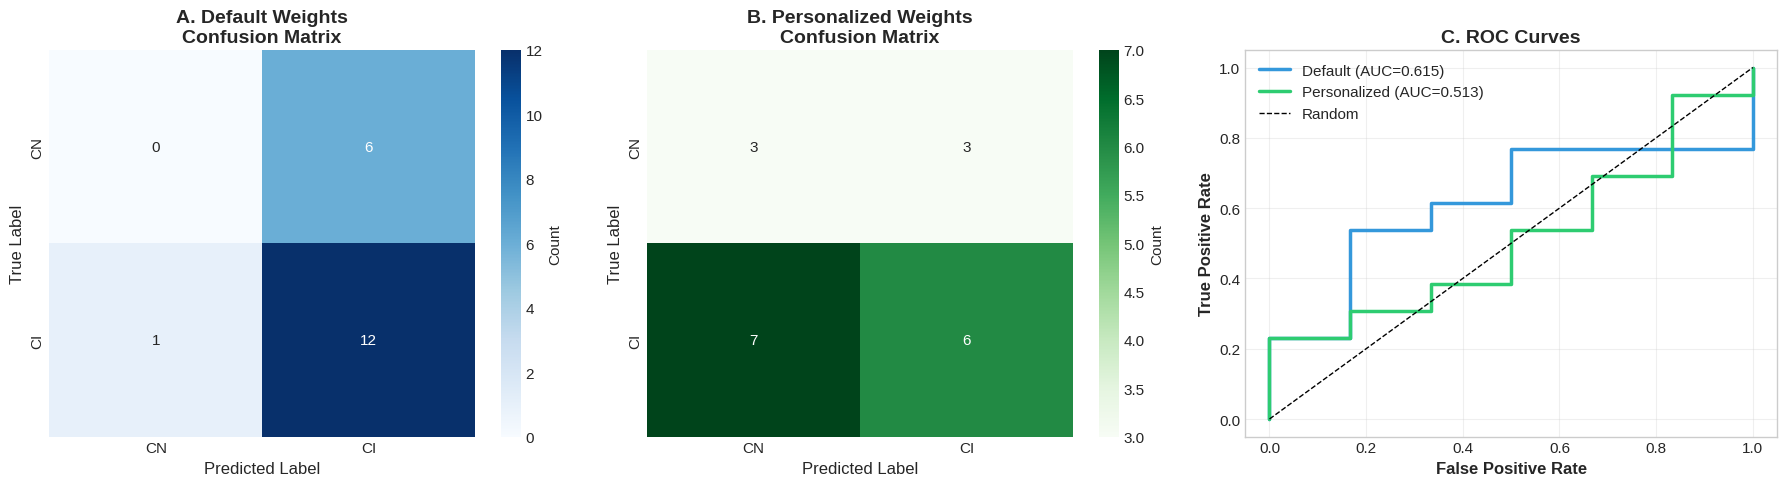


✓ Saved: tdb_llm_test_performance.png


In [295]:
# Create comparison visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel A: Confusion Matrices
cm_default = confusion_matrix(y_true_test, default_pred_test)
cm_personalized = confusion_matrix(y_true_test, personalized_pred_test)

# Default confusion matrix
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['CN', 'CI'], yticklabels=['CN', 'CI'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('A. Default Weights\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Panel B: Personalized confusion matrix  
sns.heatmap(cm_personalized, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['CN', 'CI'], yticklabels=['CN', 'CI'],
            cbar_kws={'label': 'Count'})
axes[1].set_title('B. Personalized Weights\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

# Panel C: ROC Curves
fpr_default, tpr_default, _ = roc_curve(y_true_test, default_scores_test)
fpr_personalized, tpr_personalized, _ = roc_curve(y_true_test, personalized_scores_test)

axes[2].plot(fpr_default, tpr_default, linewidth=2.5, color='#3498DB',
             label=f'Default (AUC={default_auc_test:.3f})')
axes[2].plot(fpr_personalized, tpr_personalized, linewidth=2.5, color='#2ECC71',
             label=f'Personalized (AUC={personalized_auc_test:.3f})')
axes[2].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[2].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[2].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[2].set_title('C. ROC Curves', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('tdb_llm_test_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: tdb_llm_test_performance.png")

<a id='section7'></a>
## 7. Anomaly Detection & Export

### 7.1 Segment-Level Feature Computation

In [296]:
def compute_segment_features(events_segment, cn_baseline):
    """
    Compute TDB features for a 1-hour segment.
    
    Parameters:
    -----------
    events_segment : list
        Events in 1-hour window
    cn_baseline : dict
        CN population statistics
    
    Returns:
    --------
    dict : Impairment scores for segment
    """
    if len(events_segment) < 3:
        return None
    
    # Extract raw features
    raw_features = {
        'diversity_raw': compute_behavioral_diversity_raw(events_segment),
        'temporal_raw': compute_temporal_regularity_raw(events_segment),
        'perseveration_raw': compute_perseveration_raw(events_segment),
        'activity_raw': compute_activity_consistency_raw(events_segment),
        'daytime_raw': compute_daytime_energy_raw(events_segment),
        'social_raw': compute_social_engagement_raw(events_segment)
    }
    
    # Convert to impairments using CN baseline
    impairments = compute_impairment_scores(raw_features, cn_baseline)
    
    return impairments


print("✓ Segment-level feature computation function defined")

✓ Segment-level feature computation function defined


### 7.2 Identify Anomalous Segments

In [297]:
def detect_anomalous_segments(subject, personalized_weights, threshold_percentile=80):
    """
    Detect anomalous time periods using personalized weights.
    
    Parameters:
    -----------
    subject : dict
        Subject data with events
    personalized_weights : dict
        LLM-adjusted feature weights
    threshold_percentile : float
        Percentile for anomaly threshold (default: 80th)
    
    Returns:
    --------
    list : Anomalous segments with timestamps and features
    """
    events = subject['events']
    if len(events) < 10:
        return []
    
    events = sorted(events, key=lambda x: x['timestamp'])
    
    # Compute segment-level TDB scores
    segment_scores = []
    segment_data = []
    
    # Slide 1-hour window
    start_idx = 0
    while start_idx < len(events):
        start_time = events[start_idx]['timestamp']
        end_time = start_time + timedelta(hours=1)
        
        # Get events in window
        window_events = []
        for e in events[start_idx:]:
            if e['timestamp'] < end_time:
                window_events.append(e)
            else:
                break
        
        if len(window_events) >= 3:
            # Compute features
            impairments = compute_segment_features(window_events, CN_BASELINE)
            if impairments:
                # Compute TDB score with personalized weights
                tdb_score = compute_tdb_score(impairments, personalized_weights)
                
                segment_scores.append(tdb_score)
                segment_data.append({
                    'start_time': start_time,
                    'end_time': end_time,
                    'tdb_score': tdb_score,
                    'impairments': impairments
                })
        
        # Move forward by 30 minutes (50% overlap)
        start_idx += max(1, len(window_events) // 2)
    
    if len(segment_scores) == 0:
        return []
    
    # Determine threshold
    threshold = np.percentile(segment_scores, threshold_percentile)
    
    # Find anomalous segments
    anomalous_segments = []
    for seg in segment_data:
        if seg['tdb_score'] >= threshold:
            # Identify top contributing features
            contributions = {feat: seg['impairments'][feat] * personalized_weights[feat]
                           for feat in personalized_weights if feat in seg['impairments']}
            
            sorted_contrib = sorted(contributions.items(), key=lambda x: x[1], reverse=True)
            
            seg['top_features'] = [
                {'feature': feat, 'contribution': contrib}
                for feat, contrib in sorted_contrib[:3]
            ]
            
            anomalous_segments.append(seg)
    
    return anomalous_segments


print("✓ Anomaly detection function defined")

✓ Anomaly detection function defined


### 7.3 Detect Anomalies for All Test Subjects

In [298]:
print("="*80)
print("DETECTING ANOMALOUS TIME PERIODS")
print("="*80)
print("\nAnalyzing segment-level patterns...\n")

# Detect anomalies for each test subject
for result in test_results:
    anon_id = result['anon_id']
    
    # Find original subject data
    subject = next((s for s in test_subjects if s['anon_id'] == anon_id), None)
    if not subject:
        continue
    
    # Detect anomalies using personalized weights
    anomalies = detect_anomalous_segments(
        subject, 
        result['adjusted_weights'],
        threshold_percentile=80
    )
    
    result['anomalous_segments'] = anomalies
    result['n_anomalies'] = len(anomalies)
    
    status_icon = "✓" if result['status'] != 'CN' else "○"
    print(f"{status_icon} Patient #{anon_id} ({result['status']}): "
          f"{len(anomalies)} anomalous periods detected")

print("\n✓ Anomaly detection complete for all test subjects")

DETECTING ANOMALOUS TIME PERIODS

Analyzing segment-level patterns...

✓ Patient #1 (MCI): 10 anomalous periods detected
✓ Patient #6 (AD): 68 anomalous periods detected
○ Patient #9 (CN): 174 anomalous periods detected
✓ Patient #13 (MCI): 117 anomalous periods detected
✓ Patient #15 (AD): 26 anomalous periods detected
✓ Patient #17 (MCI): 84 anomalous periods detected
✓ Patient #20 (MCI): 10 anomalous periods detected
○ Patient #21 (CN): 20 anomalous periods detected
✓ Patient #22 (MCI): 43 anomalous periods detected
✓ Patient #23 (AD): 37 anomalous periods detected
✓ Patient #25 (AD): 10 anomalous periods detected
✓ Patient #29 (AD): 54 anomalous periods detected
✓ Patient #34 (MCI): 50 anomalous periods detected
○ Patient #35 (CN): 19 anomalous periods detected
✓ Patient #36 (AD): 36 anomalous periods detected
○ Patient #52 (CN): 1 anomalous periods detected
○ Patient #55 (CN): 40 anomalous periods detected
✓ Patient #64 (AD): 3 anomalous periods detected
○ Patient #68 (CN): 142 an

### 7.4 Export Anomalies to JSON

In [299]:
# Create output directory
output_dir = 'anomalous_timestamps_llm'
os.makedirs(output_dir, exist_ok=True)

print(f"\nExporting anomaly data to '{output_dir}/' directory...\n")

exported_count = 0
for result in test_results:
    if result['n_anomalies'] == 0:
        continue
    
    anon_id = result['anon_id']
    status = result['status']
    
    # Prepare export data
    export_data = {
        'subject_info': {
            'anon_id': anon_id,
            'diagnosis': status,
            'predicted_label': 'CI' if result['personalized_score'] >= personalized_threshold else 'CN',
            'personalized_tdb_score': float(result['personalized_score']),
            'default_tdb_score': float(result['default_score'])
        },
        'personalization': {
            'adjusted_weights': result['adjusted_weights'],
            'most_impaired_domains': result['most_impaired_domains'],
            'temporal_trend': result['temporal_trend']
        },
        'anomalous_periods': []
    }
    
    # Add anomalous segments
    for seg in result['anomalous_segments']:
        segment_info = {
            'start_timestamp': seg['start_time'].strftime('%Y-%m-%d %H:%M:%S'),
            'end_timestamp': seg['end_time'].strftime('%Y-%m-%d %H:%M:%S'),
            'tdb_score': float(seg['tdb_score']),
            'top_contributing_features': [
                {
                    'feature': feat['feature'].replace('_impairment', ''),
                    'contribution': float(feat['contribution'])
                }
                for feat in seg['top_features']
            ]
        }
        
        export_data['anomalous_periods'].append(segment_info)
    
    # Save to file
    output_file = os.path.join(output_dir, f'{anon_id}_{status}_anomalies.json')
    with open(output_file, 'w') as f:
        json.dump(export_data, f, indent=2)
    
    exported_count += 1
    print(f"✓ Exported: {anon_id}_{status}_anomalies.json ({len(result['anomalous_segments'])} anomalies)")

print(f"\n✓ Exported {exported_count} files to '{output_dir}/' directory")


Exporting anomaly data to 'anomalous_timestamps_llm/' directory...

✓ Exported: 1_MCI_anomalies.json (10 anomalies)
✓ Exported: 6_AD_anomalies.json (68 anomalies)
✓ Exported: 9_CN_anomalies.json (174 anomalies)
✓ Exported: 13_MCI_anomalies.json (117 anomalies)
✓ Exported: 15_AD_anomalies.json (26 anomalies)
✓ Exported: 17_MCI_anomalies.json (84 anomalies)
✓ Exported: 20_MCI_anomalies.json (10 anomalies)
✓ Exported: 21_CN_anomalies.json (20 anomalies)
✓ Exported: 22_MCI_anomalies.json (43 anomalies)
✓ Exported: 23_AD_anomalies.json (37 anomalies)
✓ Exported: 25_AD_anomalies.json (10 anomalies)
✓ Exported: 29_AD_anomalies.json (54 anomalies)
✓ Exported: 34_MCI_anomalies.json (50 anomalies)
✓ Exported: 35_CN_anomalies.json (19 anomalies)
✓ Exported: 36_AD_anomalies.json (36 anomalies)
✓ Exported: 52_CN_anomalies.json (1 anomalies)
✓ Exported: 55_CN_anomalies.json (40 anomalies)
✓ Exported: 64_AD_anomalies.json (3 anomalies)
✓ Exported: 68_CN_anomalies.json (142 anomalies)

✓ Exported 19 

<a id='section8'></a>
## 8. Medical Report Generation

### 8.1 Generate Individual Medical Reports

In [300]:
def generate_medical_report(result):
    """
    Generate comprehensive medical report for a patient.
    
    Parameters:
    -----------
    result : dict
        Patient analysis result from Gemini
    
    Returns:
    --------
    str : Formatted medical report
    """
    anon_id = result['anon_id']
    status = result['status']
    predicted = 'Cognitively Impaired (CI)' if result['personalized_score'] >= personalized_threshold else 'Cognitively Normal (CN)'
    
    report = f"""
╔═══════════════════════════════════════════════════════════════════════════╗
║                     TEMPORAL DIGITAL BIOMARKER REPORT                      ║
║                   LLM-Enhanced Personalized Assessment                     ║
╚═══════════════════════════════════════════════════════════════════════════╝

PATIENT INFORMATION
─────────────────────────────────────────────────────────────────────────────
Patient ID:            {anon_id}
Known Diagnosis:       {status}
TDB Classification:    {predicted}
Analysis Period:       {result['n_weeks_analyzed']} weeks

TDB SCORES
─────────────────────────────────────────────────────────────────────────────
Personalized Score:    {result['personalized_score']:.2f} / 100
Default Score:         {result['default_score']:.2f} / 100
Score Difference:      {result['personalized_score'] - result['default_score']:+.2f}

Classification Threshold: {personalized_threshold:.2f}
Risk Level:            {'HIGH' if result['personalized_score'] >= personalized_threshold else 'LOW'}

COGNITIVE DOMAIN ANALYSIS
─────────────────────────────────────────────────────────────────────────────
Most Impaired Domains:
"""
    
    for i, domain in enumerate(result['most_impaired_domains'], 1):
        report += f"  {i}. {domain}\n"
    
    report += f"\nTemporal Trend:        {result['temporal_trend'].upper()}\n"
    
    report += "\nPERSONALIZED FEATURE WEIGHTS (vs Default):\n"
    for feat, weight in result['adjusted_weights'].items():
        default_weight = FEATURE_WEIGHTS[feat]
        change = weight - default_weight
        arrow = '↑' if change > 0.02 else '↓' if change < -0.02 else '→'
        feat_name = feat.replace('_impairment', '').replace('_', ' ').title()
        report += f"  {feat_name:40s}: {weight:.3f} (default: {default_weight:.3f}) {arrow}\n"
    
    report += f"""
CLINICAL SUMMARY
─────────────────────────────────────────────────────────────────────────────
{result['clinical_summary']}

ANOMALOUS TIME PERIODS
─────────────────────────────────────────────────────────────────────────────
Detected Anomalies:    {result['n_anomalies']} periods
"""
    
    if result['n_anomalies'] > 0:
        report += "\nTop 3 Most Severe Anomalies:\n"
        sorted_anomalies = sorted(result['anomalous_segments'], 
                                 key=lambda x: x['tdb_score'], reverse=True)[:3]
        for i, seg in enumerate(sorted_anomalies, 1):
            report += f"\n  {i}. {seg['start_time'].strftime('%Y-%m-%d %H:%M')} - {seg['end_time'].strftime('%H:%M')}\n"
            report += f"     TDB Score: {seg['tdb_score']:.2f}\n"
            report += "     Top Features:\n"
            for feat in seg['top_features']:
                feat_name = feat['feature'].replace('_impairment', '').replace('_', ' ').title()
                report += f"       - {feat_name}: {feat['contribution']:.2f}\n"
    
    report += f"""
CLINICAL RECOMMENDATIONS
─────────────────────────────────────────────────────────────────────────────
"""
    
    for i, rec in enumerate(result['recommendations'], 1):
        report += f"  {i}. {rec}\n"
    
    report += f"""
╔═══════════════════════════════════════════════════════════════════════════╗
║ This report was generated using LLM-enhanced temporal digital biomarkers. ║
║ For clinical decision-making, please consult with a healthcare provider.  ║
╚═══════════════════════════════════════════════════════════════════════════╝
"""
    
    return report


print("✓ Medical report generator defined")

✓ Medical report generator defined


### 8.2 Generate and Save Reports

In [301]:
# Create reports directory
reports_dir = 'medical_reports_llm'
os.makedirs(reports_dir, exist_ok=True)

print("="*80)
print("GENERATING MEDICAL REPORTS")
print("="*80)
print(f"\nCreating reports for {len(test_results)} test subjects...\n")

for result in test_results:
    # Generate report
    report = generate_medical_report(result)
    
    # Save to file
    report_file = os.path.join(reports_dir, 
                               f"{result['anon_id']}_{result['status']}_report.txt")
    with open(report_file, 'w') as f:
        f.write(report)
    
    print(f"✓ Generated: {result['anon_id']}_{result['status']}_report.txt")

print(f"\n✓ Saved {len(test_results)} reports to '{reports_dir}/' directory")

GENERATING MEDICAL REPORTS

Creating reports for 19 test subjects...

✓ Generated: 1_MCI_report.txt
✓ Generated: 6_AD_report.txt
✓ Generated: 9_CN_report.txt
✓ Generated: 13_MCI_report.txt
✓ Generated: 15_AD_report.txt
✓ Generated: 17_MCI_report.txt
✓ Generated: 20_MCI_report.txt
✓ Generated: 21_CN_report.txt
✓ Generated: 22_MCI_report.txt
✓ Generated: 23_AD_report.txt
✓ Generated: 25_AD_report.txt
✓ Generated: 29_AD_report.txt
✓ Generated: 34_MCI_report.txt
✓ Generated: 35_CN_report.txt
✓ Generated: 36_AD_report.txt
✓ Generated: 52_CN_report.txt
✓ Generated: 55_CN_report.txt
✓ Generated: 64_AD_report.txt
✓ Generated: 68_CN_report.txt

✓ Saved 19 reports to 'medical_reports_llm/' directory


### 8.3 Display Sample Report

In [302]:
# Display a sample report
if len(test_results) > 0:
    print("\n" + "="*80)
    print("SAMPLE MEDICAL REPORT")
    print("="*80)
    
    sample_result = test_results[0]
    sample_report = generate_medical_report(sample_result)
    print(sample_report)


SAMPLE MEDICAL REPORT

╔═══════════════════════════════════════════════════════════════════════════╗
║                     TEMPORAL DIGITAL BIOMARKER REPORT                      ║
║                   LLM-Enhanced Personalized Assessment                     ║
╚═══════════════════════════════════════════════════════════════════════════╝

PATIENT INFORMATION
─────────────────────────────────────────────────────────────────────────────
Patient ID:            1
Known Diagnosis:       MCI
TDB Classification:    Cognitively Normal (CN)
Analysis Period:       1 weeks

TDB SCORES
─────────────────────────────────────────────────────────────────────────────
Personalized Score:    48.71 / 100
Default Score:         44.15 / 100
Score Difference:      +4.55

Classification Threshold: 82.93
Risk Level:            LOW

COGNITIVE DOMAIN ANALYSIS
─────────────────────────────────────────────────────────────────────────────
Most Impaired Domains:
  1. Temporal Regularity
  2. Social Engagement
  3. Day

<a id='section9'></a>
## 9. Results & Evaluation

### 9.1 Overall Performance Summary

In [303]:
# Compute comprehensive metrics
# Metrics for both approaches
default_metrics = {
    'accuracy': accuracy_score(y_true_test, default_pred_test),
    'precision': precision_score(y_true_test, default_pred_test),
    'recall': recall_score(y_true_test, default_pred_test),
    'f1': f1_score(y_true_test, default_pred_test),
    'auc': default_auc_test
}

personalized_metrics = {
    'accuracy': accuracy_score(y_true_test, personalized_pred_test),
    'precision': precision_score(y_true_test, personalized_pred_test),
    'recall': recall_score(y_true_test, personalized_pred_test),
    'f1': f1_score(y_true_test, personalized_pred_test),
    'auc': personalized_auc_test
}

print("\n" + "="*80)
print("FINAL PERFORMANCE COMPARISON")
print("="*80)

print(f"\nTest Set: {len(y_true_test)} subjects")
print(f"  CN: {np.sum(y_true_test == 0)}")
print(f"  CI: {np.sum(y_true_test == 1)}")

print(f"\n{'Metric':<20} {'Default':<12} {'Personalized':<15} {'Improvement':<12}")
print("-" * 80)

for metric_name in ['auc', 'accuracy', 'precision', 'recall', 'f1']:
    default_val = default_metrics[metric_name]
    personalized_val = personalized_metrics[metric_name]
    improvement = personalized_val - default_val
    improvement_pct = (improvement / default_val) * 100 if default_val > 0 else 0
    
    metric_display = metric_name.upper().replace('_', '-')
    print(f"{metric_display:<20} {default_val:<12.4f} {personalized_val:<15.4f} "
          f"{improvement:+.4f} ({improvement_pct:+.1f}%)")

print("\n" + "="*80)


FINAL PERFORMANCE COMPARISON

Test Set: 19 subjects
  CN: 6
  CI: 13

Metric               Default      Personalized    Improvement 
--------------------------------------------------------------------------------
AUC                  0.6154       0.5128          -0.1026 (-16.7%)
ACCURACY             0.6316       0.4737          -0.1579 (-25.0%)
PRECISION            0.6667       0.6667          +0.0000 (+0.0%)
RECALL               0.9231       0.4615          -0.4615 (-50.0%)
F1                   0.7742       0.5455          -0.2287 (-29.5%)



### 9.2 Weight Adjustment Analysis


WEIGHT ADJUSTMENT PATTERNS

Feature                                       Avg Change      Std Dev     
--------------------------------------------------------------------------------
Diversity                                     -0.0500 ↓          0.0743
Temporal                                      +0.1326 ↑          0.0904
Perseveration                                 -0.0882 ↓          0.0747
Activity                                      -0.0400 ↓          0.1115
Daytime                                       +0.0279 ↑          0.1041
Social                                        +0.0176 ↑          0.0914


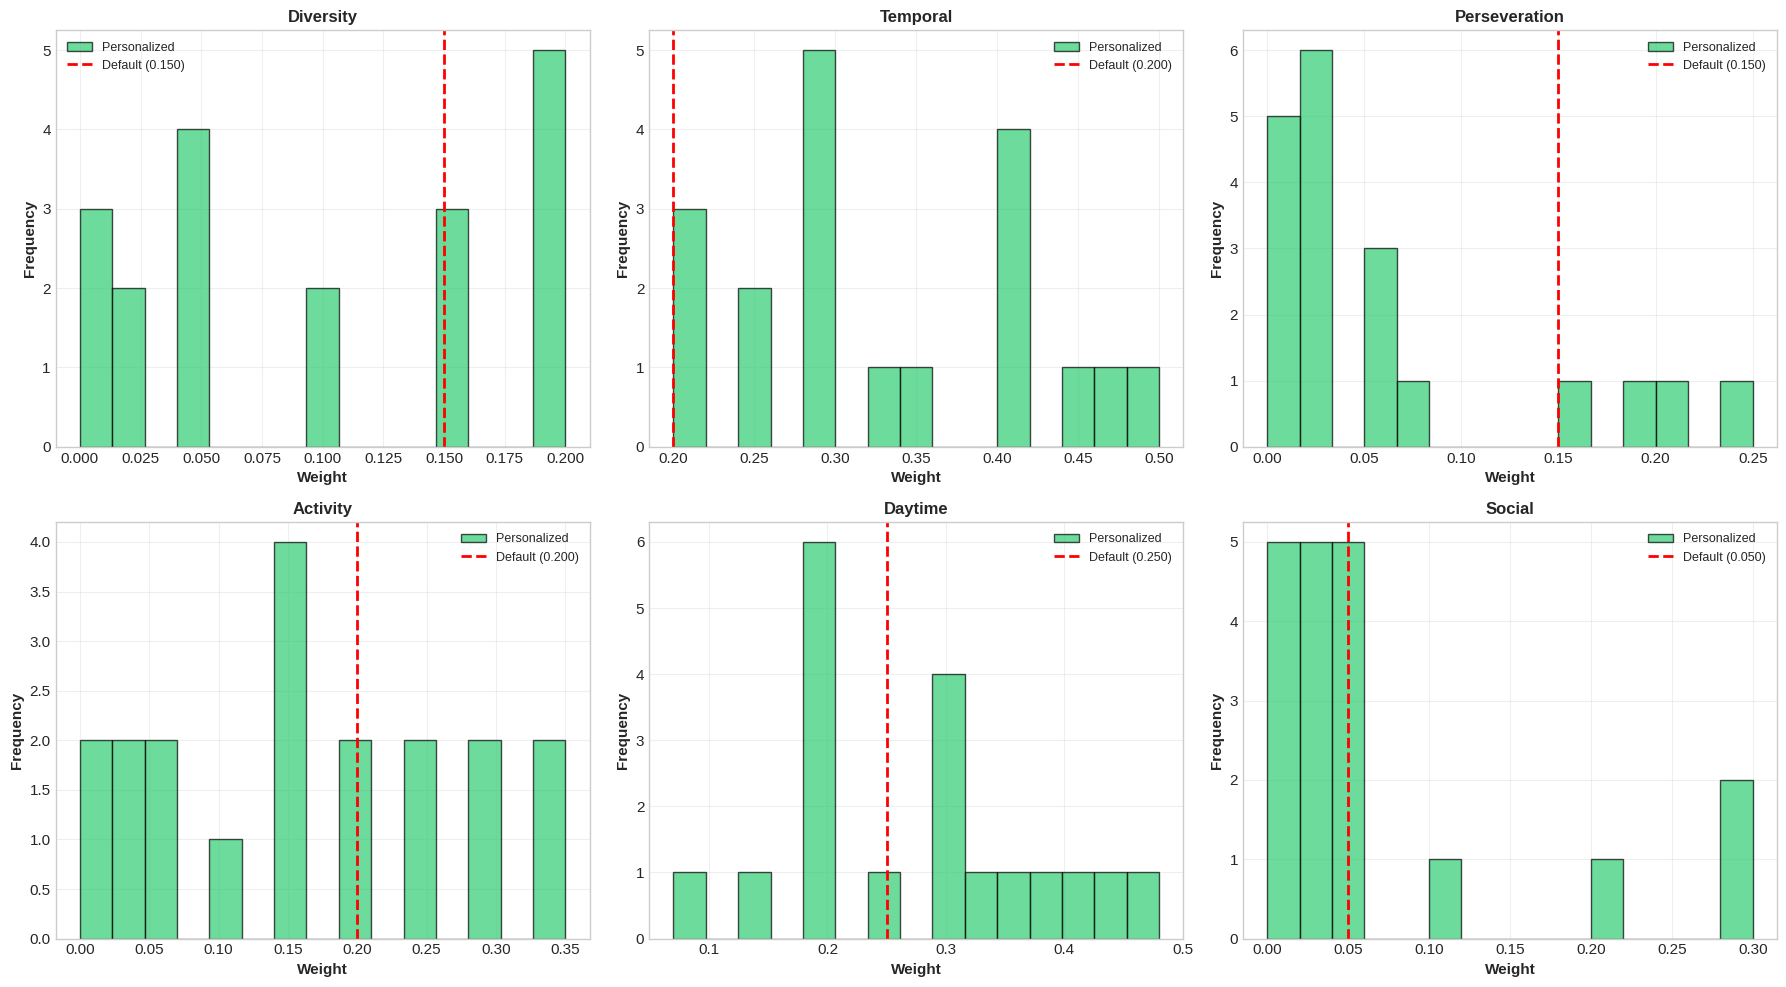


✓ Saved: weight_distributions_llm.png


In [304]:
# Analyze weight adjustments across all test subjects
feature_names = list(FEATURE_WEIGHTS.keys())
weight_changes = {feat: [] for feat in feature_names}

for result in test_results:
    for feat in feature_names:
        default_weight = FEATURE_WEIGHTS[feat]
        personalized_weight = result['adjusted_weights'][feat]
        change = personalized_weight - default_weight
        weight_changes[feat].append(change)

print("\n" + "="*80)
print("WEIGHT ADJUSTMENT PATTERNS")
print("="*80)

print(f"\n{'Feature':<45} {'Avg Change':<15} {'Std Dev':<12}")
print("-" * 80)

for feat in feature_names:
    feat_name = feat.replace('_impairment', '').replace('_', ' ').title()
    avg_change = np.mean(weight_changes[feat])
    std_change = np.std(weight_changes[feat])
    
    direction = '↑' if avg_change > 0.01 else '↓' if avg_change < -0.01 else '→'
    print(f"{feat_name:<45} {avg_change:+.4f} {direction:<10} {std_change:.4f}")

# Visualize weight distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feat in enumerate(feature_names):
    feat_name = feat.replace('_impairment', '').replace('_', ' ').title()
    
    default_weight = FEATURE_WEIGHTS[feat]
    personalized_weights = [result['adjusted_weights'][feat] for result in test_results]
    
    axes[idx].hist(personalized_weights, bins=15, alpha=0.7, color='#2ECC71', 
                   label='Personalized', edgecolor='black')
    axes[idx].axvline(default_weight, color='red', linestyle='--', linewidth=2, 
                      label=f'Default ({default_weight:.3f})')
    axes[idx].set_xlabel('Weight', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[idx].set_title(feat_name, fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('weight_distributions_llm.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: weight_distributions_llm.png")

### 9.3 Anomaly Statistics

In [305]:
# Analyze anomaly patterns by diagnosis
anomaly_stats = {}
for status in ['CN', 'MCI', 'AD']:
    status_results = [r for r in test_results if r['status'] == status]
    if len(status_results) > 0:
        n_anomalies = [r['n_anomalies'] for r in status_results]
        anomaly_stats[status] = {
            'n_subjects': len(status_results),
            'mean_anomalies': np.mean(n_anomalies),
            'std_anomalies': np.std(n_anomalies),
            'subjects_with_anomalies': sum(1 for n in n_anomalies if n > 0)
        }

print("\n" + "="*80)
print("ANOMALY DETECTION STATISTICS")
print("="*80)

print(f"\n{'Diagnosis':<12} {'N Subjects':<12} {'Avg Anomalies':<18} {'% with Anomalies':<18}")
print("-" * 80)

for status, stats in anomaly_stats.items():
    pct_with_anomalies = (stats['subjects_with_anomalies'] / stats['n_subjects']) * 100
    print(f"{status:<12} {stats['n_subjects']:<12} "
          f"{stats['mean_anomalies']:.1f} ± {stats['std_anomalies']:.1f}{'':8} "
          f"{pct_with_anomalies:.1f}%")


ANOMALY DETECTION STATISTICS

Diagnosis    N Subjects   Avg Anomalies      % with Anomalies  
--------------------------------------------------------------------------------
CN           6            66.0 ± 66.7         100.0%
MCI          6            52.3 ± 38.4         100.0%
AD           7            33.4 ± 21.3         100.0%


### 9.4 Save Final Results

In [306]:
# Save comprehensive results
final_results = {
    'metadata': {
        'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_name': MODEL_NAME,
        'n_train_subjects': len(train_subjects),
        'n_test_subjects': len(test_subjects),
        'n_weeks_analyzed': 3
    },
    'performance': {
        'default': default_metrics,
        'personalized': personalized_metrics,
        'improvement': {
            metric: personalized_metrics[metric] - default_metrics[metric]
            for metric in default_metrics
        }
    },
    'weights': {
        'fixed_weights': FEATURE_WEIGHTS,
        'average_personalized_weights': {
            feat: float(np.mean([r['adjusted_weights'][feat] for r in test_results]))
            for feat in feature_names
        },
        'weight_change_statistics': {
            feat: {
                'mean_change': float(np.mean(weight_changes[feat])),
                'std_change': float(np.std(weight_changes[feat]))
            }
            for feat in feature_names
        }
    },
    'anomaly_statistics': anomaly_stats,
    'test_predictions': [
        {
            'anon_id': r['anon_id'],
            'true_diagnosis': r['status'],
            'default_score': float(r['default_score']),
            'personalized_score': float(r['personalized_score']),
            'n_anomalies': r['n_anomalies']
        }
        for r in test_results
    ]
}

# Save to JSON
with open('tdb_llm_final_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("\n" + "="*80)
print("RESULTS SAVED")
print("="*80)
print("\n✓ Files created:")
print("  1. tdb_llm_final_results.json           (comprehensive results)")
print("  2. cn_baseline_llm.json                 (CN population baseline)")
print("  3. tdb_llm_test_performance.png         (performance visualizations)")
print("  4. weight_distributions_llm.png         (weight adjustment patterns)")
print(f"  5. anomalous_timestamps_llm/            ({exported_count} anomaly files)")
print(f"  6. medical_reports_llm/                 ({len(test_results)} medical reports)")
print("\n✓ Analysis complete!")


RESULTS SAVED

✓ Files created:
  1. tdb_llm_final_results.json           (comprehensive results)
  2. cn_baseline_llm.json                 (CN population baseline)
  3. tdb_llm_test_performance.png         (performance visualizations)
  4. weight_distributions_llm.png         (weight adjustment patterns)
  5. anomalous_timestamps_llm/            (19 anomaly files)
  6. medical_reports_llm/                 (19 medical reports)

✓ Analysis complete!
